<a href="https://colab.research.google.com/github/suwisitlk/229352-StatisticalLearning/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [3]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [5]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [6]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader


In [7]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True) #เพิ่มความหลากหลายของข้อมูล
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [8]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [9]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

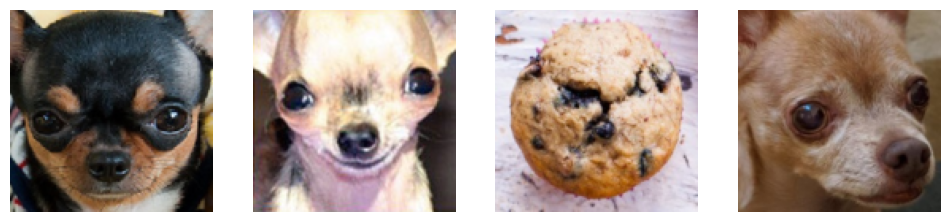

tensor([0, 0, 1, 0])


In [10]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [11]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super().__init__() #เรียก attribute ก่อน
    self.flatten = nn.Flatten() #คลี่รูปภาพออกเป็นเวกเตอร์ยาวๆ  // ฝั่งซ้ายฝั่งขวาไม่เหมือนกัน
    self.lin1 = nn.Linear(128 * 128 * 3, 100) #input , output ความยาวเหลือ 100
    self.act1 = nn.ReLU() #ReLU
    self.lin2 = nn.Linear(100, 50) #เรา output มาจากข้างบน
    self.act2 = nn.ReLU()
    self.lin3 = nn.Linear(50, 1) #prob ที่ y = 1

  def forward(self, x): #ใน forward part เราต้องผ่านอะไรบ้าง
    x = self.flatten(x) # x ที่เกิดจะเป็นภาพที่เกิดจากการคลี่
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [12]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()

#### Manually setting initial weights to zero for demonstration

In [13]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [14]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [15]:
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [16]:
X, y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [17]:
y_hat = model(X)

#เปลี่ยน y, y_hat เพื่ออยู่ในรูปที่เหมาะสม
y = y.to(torch.float32)
y_hat = y_hat[:, 0] #แทนที่จะเป็นเวกเตอร์ก็เป็นเลขตัวเดียว

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [18]:
# Compute the loss
train_loss = criterion(y_hat, y)
train_losses.append(train_loss)


#### Calculate the gradient (Backward pass)

In [ ]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters


In [19]:
model.parameters()

<generator object Module.parameters at 0x7e5f087baf80>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [20]:
# Manually update the weights using the gradient descent rule
optimizer.step() #parameter = learning rate * gradient_of_parameter

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    print(y, y_hat)
    print(y.shape)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [ ]:
print(train_losses)
print(val_losses)

#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

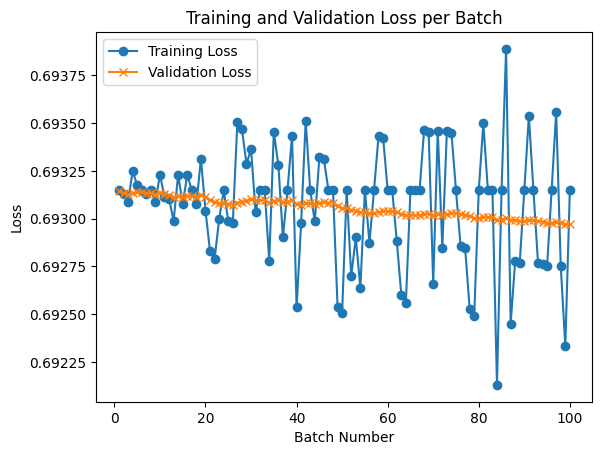

In [21]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# เปลี่่ยนพารามิเตอร์ให้กลายเป็น 0
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []


for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y_hat = torch.sigmoid(y_hat) # Apply sigmoid to convert logits to probabilities
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y_hat = torch.sigmoid(y_hat) # Apply sigmoid to convert logits to probabilities
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss.item()) # Append the item() of the tensor

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [33]:
# Load images, resize them to 224 * 224 , and normalize the pixels to be in 0 - 1 range
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


#### Load the datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True) #เพิ่มความหลากหลายของข้อมูล
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)



In [34]:
# 1. Create a neural network with 3 hidden layers as shown in the picture.
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # คลี่รูปภาพ 128x128x3 เป็นเวกเตอร์ขนาด 49,152

        # --- Hidden Layer 1 ---
        self.lin1 = nn.Linear(224 * 224 * 3, 128)
        self.act1 = nn.ReLU()

        # --- Hidden Layer 2 ---
        self.lin2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()

        # --- Hidden Layer 3 ---
        self.lin3 = nn.Linear(64, 32)
        self.act3 = nn.ReLU()

        # --- Output Layer ---
        self.lin4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.act1(self.lin1(x))
        x = self.act2(self.lin2(x))
        x = self.act3(self.lin3(x))
        x = self.lin4(x) # ส่งค่า Logit ออกไป (เดี๋ยวไปใส่ Sigmoid ใน Loop เทรน)
        return x

In [35]:
# 2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5,

# 2.1. กำหนดรายการ Learning Rate
lrs = [1e-2, 1e-3, 1e-4, 1e-5]
comparison_results = {}

for lr in lrs:
    print(f"กำลังเริ่มฝึกฝนด้วย Learning Rate: {lr}")

    # 2.2. สร้างโมเดลใหม่ทุกลูป (3 Hidden Layers ตามที่ออกแบบไว้)
    model = MyNeuralNetwork()

    # เลือกใช้ AdamW หรือ SGD ตามความเหมาะสม
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    criterion = nn.BCELoss() # หากใช้ 1 output node

    train_losses = []

    # 2.3. Training Loop (กำหนดจำนวน Epoch ที่เหมาะสม)
    for epoch in range(10):
        model.train()
        running_loss = 0.0

        for X, y in train_loader:
            # Forward Pass
            y_hat = torch.sigmoid(model(X)[:, 0])
            loss = criterion(y_hat, y.to(torch.float32))

            # Backward Pass & Optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

    # เก็บผลลัพธ์ไว้ใน Dictionary เพื่อนำไป Plot
    comparison_results[lr] = train_losses

    comparison_results[lr]

กำลังเริ่มฝึกฝนด้วย Learning Rate: 0.01
กำลังเริ่มฝึกฝนด้วย Learning Rate: 0.001
กำลังเริ่มฝึกฝนด้วย Learning Rate: 0.0001
กำลังเริ่มฝึกฝนด้วย Learning Rate: 1e-05


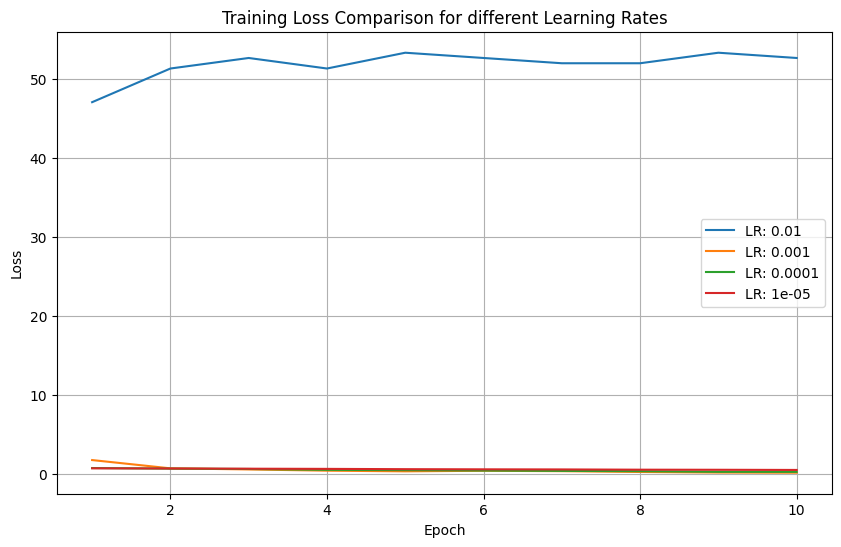

In [36]:
plt.figure(figsize=(10, 6))
for lr, losses in comparison_results.items():
    plt.plot(range(1, 11), losses, label=f'LR: {lr}')

plt.title('Training Loss Comparison for different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

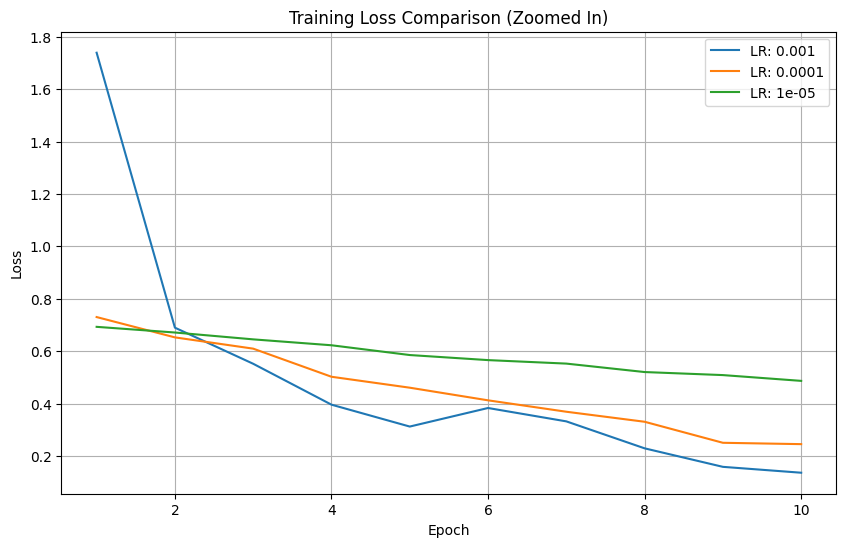

In [48]:
plt.figure(figsize=(10, 6))

# วนลูปเช็คค่า LR ก่อนพล็อต
for lr, losses in comparison_results.items():
    if lr == 0.01: # ถ้าเป็น 0.01 ให้ข้ามไปเลย ไม่ต้องวาด
        continue
    plt.plot(range(1, 11), losses, label=f'LR: {lr}')

plt.title('Training Loss Comparison (Zoomed In)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 2.1 What value of learning rate do you think is best? Please explain your reason.

*   rl = 0.001 เนื่องจากมีการลดที่รวดเร็วซึ่งหมายความว่าโมเดลเรียนรู้ไว และ ค่า Loss ต่ำที่สุดใน epoch ที่ 10 เมื่อเทียบกับ rl ตัวอื่น

## 2.2 What happens to the training losses if your learning rate is too large?

*  ค่า Loss จะ สูงผิดปกติและไม่ยอมลดลง ขายาวลงเกินไปจนข้ามจุดต่ำสุดไปมา ไม่ลงจุดต่ำซักที

## 2.3 What happens to the training losses if your learning rate is too small?

*  ค่า Loss จะ ลดลงช้ามากต้องใช้จำนวน Epoch มาก สูญเสียทรัพยากร๊

In [49]:
# 1. สร้างโมเดลและตั้งค่าให้ตรงกับตัวที่ชนะ (จากกราฟ)
model = MyNeuralNetwork()
best_lr = 0.001 # ค่าจากกราฟเส้นสีส้ม
optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=1e-2)
criterion = nn.BCELoss()

# 2. เทรนใหม่ 10 Epoch (เหมือนตอนทดลอง)
for epoch in range(10):
    model.train()
    for X, y in train_loader:
        y_hat = torch.sigmoid(model(X)[:, 0])
        loss = criterion(y_hat, y.to(torch.float32))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [51]:
# 3. After finish training your model. Make the predictions on the test set and compute the accuracy.
model.eval()

with torch.no_grad():
    test_batches = iter(test_loader)
    X, y = next(test_batches)

    # Forward pass
    output = model(X)

    # Apply Sigmoid
    y_prob = torch.sigmoid(output[:, 0])

    # แปลงเป็น Class 0 หรือ 1 (Threshold 0.5)
    y_hat = (y_prob > 0.5).float()

    # 4. Compute Accuracy
    correct = (y_hat == y).sum().item()
    total = y.size(0)

    accuracy = (correct / total) * 100

    print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 80.00%


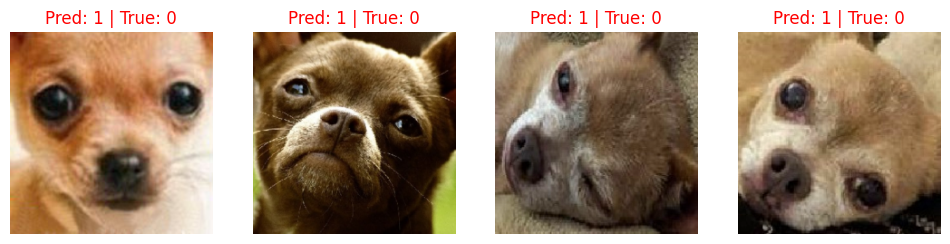

In [62]:
# 4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

# 1. หา Index ของรูปที่ทายผิด
y_hat = (torch.sigmoid(model(X)[:, 0]) > 0.5).float()
wrong_idx = (y_hat != y).nonzero(as_tuple=True)[0][:4]

if len(wrong_idx) > 0:
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(wrong_idx):
        # จัดการรูป: ย้ายแกน -> แปลงเป็น numpy -> ปรับค่าสีให้เป็น 0-1 (กันภาพมืด)
        img = X[idx].cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        # วาดรูป
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {int(y_hat[idx])} | True: {int(y[idx])}", color='red')
        plt.axis('off')
    plt.show()
else:
    print("All Correct")